In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from google.cloud import bigquery

from view_demo.utils import run_and_save

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Get Dataset

In [2]:
CSV_PATH = 'gs://view-demo-dataset/forecasting/jena_climate_2009_2016.csv'

## EDA, Pre-processing and Clean Up

In [3]:
df = pd.read_csv(csv_path)
# slice [start:stop:step], starting from index 5 take every 6th record.
df = df[5::6]

date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

In [4]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0


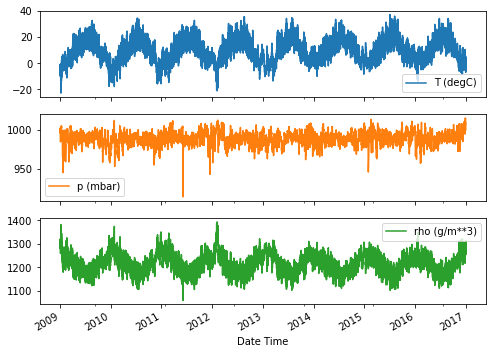

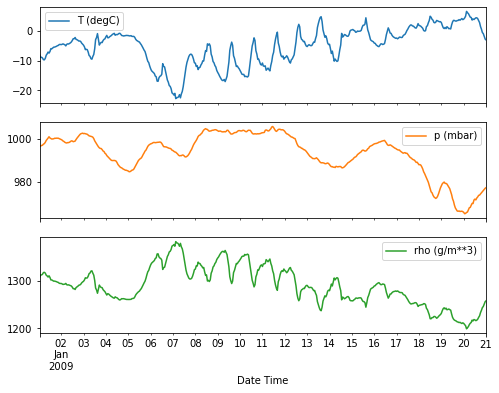

In [17]:
plot_cols = ['T (degC)', 'p (mbar)', 'rho (g/m**3)']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),70091.0,989.212842,8.358886,913.60,984.20,989.57,994.720,1015.29
T (degC),70091.0,9.450482,8.423384,-22.76,3.35,9.41,15.480,37.28
Tpot (K),70091.0,283.493086,8.504424,250.85,277.44,283.46,289.530,311.21
Tdew (degC),70091.0,4.956471,6.730081,-24.80,0.24,5.21,10.080,23.06
rh (%),70091.0,76.009788,16.474920,13.88,65.21,79.30,89.400,100.00
VPmax (mbar),70091.0,13.576576,7.739883,0.97,7.77,11.82,17.610,63.77
VPact (mbar),70091.0,9.533968,4.183658,0.81,6.22,8.86,12.360,28.25
VPdef (mbar),70091.0,4.042536,4.898549,0.00,0.87,2.19,5.300,46.01
sh (g/kg),70091.0,6.022560,2.655812,0.51,3.92,5.59,7.800,18.07
H2OC (mmol/mol),70091.0,9.640437,4.234862,0.81,6.29,8.96,12.490,28.74


Fix outlier/incorrect wind velocity

In [19]:
wv = df['wv (m/s)']
bad_wv = wv == -9999.0
wv[bad_wv] = 0.0

max_wv = df['max. wv (m/s)']
bad_max_wv = max_wv == -9999.0
max_wv[bad_max_wv] = 0.0

# The above inplace edits are reflected in the DataFrame
df['wv (m/s)'].min()

0.0

Wind Direction. Is 0-360 degrees a good range?

Text(0, 0.5, 'Wind Velocity [m/s]')

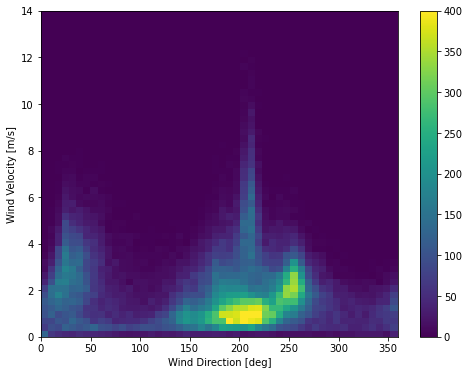

In [20]:
plt.hist2d(df['wd (deg)'], df['wv (m/s)'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

Converting to X and Y components of the velocity

In [21]:
wv = df.pop('wv (m/s)')
max_wv = df.pop('max. wv (m/s)')

# Convert to radians.
wd_rad = df.pop('wd (deg)')*np.pi / 180

# Calculate the wind x and y components.
df['Wx'] = wv*np.cos(wd_rad)
df['Wy'] = wv*np.sin(wd_rad)

# Calculate the max wind x and y components.
df['max Wx'] = max_wv*np.cos(wd_rad)
df['max Wy'] = max_wv*np.sin(wd_rad)

(-11.305513973134667, 8.24469928549079, -8.27438540335515, 7.7338312955467785)

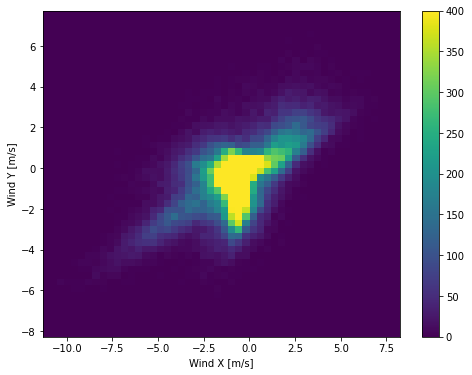

In [22]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [25]:
date_time.head()

5    2009-01-01 01:00:00
11   2009-01-01 02:00:00
17   2009-01-01 03:00:00
23   2009-01-01 04:00:00
29   2009-01-01 05:00:00
Name: Date Time, dtype: datetime64[ns]

Day, month and year as features

In [27]:
timestamp_s = date_time.map(datetime.datetime.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

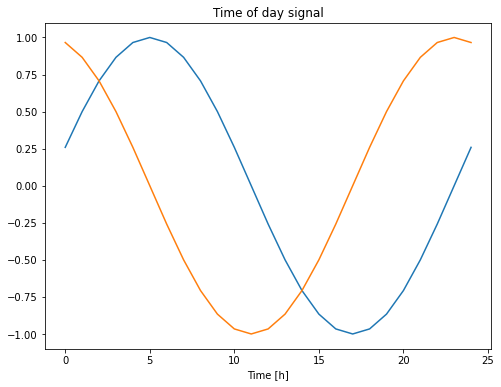

In [28]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [31]:
df['Date_Time'] = date_time

In [44]:
df['Date_Time'] = df['Date_Time'].apply(lambda x: x.strftime('%d-%m-%Y %H:%M:%S'))

In [45]:
df['Date_Time'].head()

5     01-01-2009 01:00:00
11    01-01-2009 02:00:00
17    01-01-2009 03:00:00
23    01-01-2009 04:00:00
29    01-01-2009 05:00:00
Name: Date_Time, dtype: object

In [33]:
df['Group'] = "T"

In [34]:
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),...,Wx,Wy,max Wx,max Wy,Day sin,Day cos,Year sin,Year cos,Date_Time,Group
5,996.50,-8.05,265.38,-8.78,94.4,3.33,3.14,0.19,1.96,3.15,...,-0.204862,-0.046168,-0.614587,-0.138503,0.258819,0.965926,0.010049,0.999950,2009-01-01 01:00:00,T
11,996.62,-8.88,264.54,-9.77,93.2,3.12,2.90,0.21,1.81,2.91,...,-0.245971,-0.044701,-0.619848,-0.112645,0.500000,0.866025,0.010766,0.999942,2009-01-01 02:00:00,T
17,996.84,-8.81,264.59,-9.66,93.5,3.13,2.93,0.20,1.83,2.94,...,-0.175527,0.039879,-0.614344,0.139576,0.707107,0.707107,0.011483,0.999934,2009-01-01 03:00:00,T
23,996.99,-9.05,264.34,-10.02,92.6,3.07,2.85,0.23,1.78,2.85,...,-0.050000,-0.086603,-0.190000,-0.329090,0.866025,0.500000,0.012199,0.999926,2009-01-01 04:00:00,T
29,997.46,-9.63,263.72,-10.65,92.2,2.94,2.71,0.23,1.69,2.71,...,-0.368202,0.156292,-0.810044,0.343843,0.965926,0.258819,0.012916,0.999917,2009-01-01 05:00:00,T


In [70]:
df.rename(columns={
    'p (mbar)': 'p__mbar', 
    'T (degC)': 'T__degC',
    'Tpot (K)': 'Tpot__K', 
    'Tdew (degC)': 'Tdew__degC', 
    'rh (%)': 'rh__percent',
    'VPmax (mbar)': 'VPmax__mbar' ,
    'VPact (mbar)': 'VPact__mbar',
    'VPdef (mbar)': 'VPdef__mbar',
    'sh (g/kg)': 'sh__g_per_kg',
    'H2OC (mmol/mol)': 'H2OC__mmol_per_mol',
    'rho (g/m**3)': 'rho__gm_per_cubic_m',
    'max Wx': 'max_Wx',
    'max Wy': 'max_Wy', 
    'Day sin': 'Day_sin', 
    'Day cos': 'Day_cos', 
    'Year sin': 'Year_sin', 
    'Year cos': 'Year_cos'
    
}, inplace=True)

## Create BQ Client 

In [71]:
client = bigquery.Client(location="us-central1")
print("Client creating using default project: {}".format(client.project))

Client creating using default project: pytorch-tpu-nfs


In [76]:
from google.cloud.exceptions import NotFound

# Define a name for the new dataset.
dataset_id = 'forecasting_exp'

# The project defaults to the Client's project if not specified.
try:
    dataset = client.get_dataset(dataset_id)  # Make an API request.
    print("Dataset {} already exists".format(dataset_id))
except NotFound:
    print("Dataset {} is not found, Creating..".format(dataset_id))
    dataset = client.create_dataset(dataset_id)
    
table_id = "weather_time_series"
table_ref = dataset.table(table_id)

job_config = bigquery.LoadJobConfig(
    destination=table_ref,
    autodetect=True,
)
job_config.write_disposition = 'WRITE_TRUNCATE'

job = client.load_table_from_dataframe(df, table_ref, location="us-central1")
job.result()  # Waits for table load to complete.
print("Loaded dataframe to {}".format(table_ref.path))

Dataset forecasting_exp already exists
Loaded dataframe to /projects/pytorch-tpu-nfs/datasets/forecasting_exp/tables/weather_time_series


In [92]:
df.pop('Date_Time')
df.pop('Group')


In [93]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [94]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

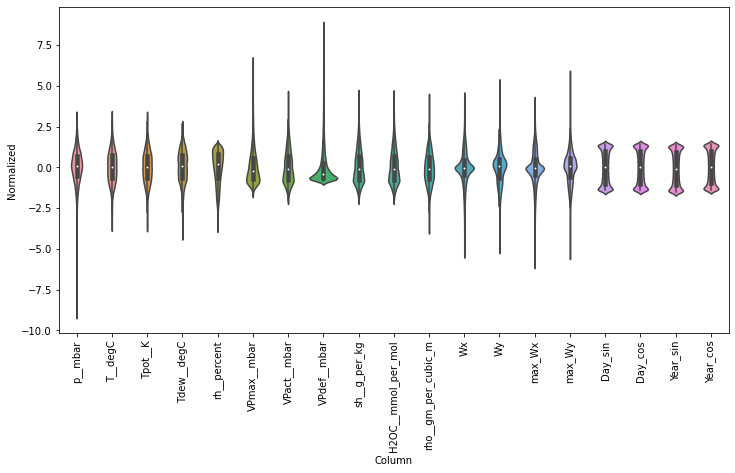

In [96]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

In [99]:
table_ref

TableReference(DatasetReference('pytorch-tpu-nfs', 'forecasting_exp'), 'weather_time_series')

In [104]:
a = df.columns.tolist()

In [105]:
[{'numeric': {'column_name': i}} for i in a]

[{'numeric': {'column_name': 'p__mbar'}},
 {'numeric': {'column_name': 'T__degC'}},
 {'numeric': {'column_name': 'Tpot__K'}},
 {'numeric': {'column_name': 'Tdew__degC'}},
 {'numeric': {'column_name': 'rh__percent'}},
 {'numeric': {'column_name': 'VPmax__mbar'}},
 {'numeric': {'column_name': 'VPact__mbar'}},
 {'numeric': {'column_name': 'VPdef__mbar'}},
 {'numeric': {'column_name': 'sh__g_per_kg'}},
 {'numeric': {'column_name': 'H2OC__mmol_per_mol'}},
 {'numeric': {'column_name': 'rho__gm_per_cubic_m'}},
 {'numeric': {'column_name': 'Wx'}},
 {'numeric': {'column_name': 'Wy'}},
 {'numeric': {'column_name': 'max_Wx'}},
 {'numeric': {'column_name': 'max_Wy'}},
 {'numeric': {'column_name': 'Day_sin'}},
 {'numeric': {'column_name': 'Day_cos'}},
 {'numeric': {'column_name': 'Year_sin'}},
 {'numeric': {'column_name': 'Year_cos'}}]

In [106]:
a

['p__mbar',
 'T__degC',
 'Tpot__K',
 'Tdew__degC',
 'rh__percent',
 'VPmax__mbar',
 'VPact__mbar',
 'VPdef__mbar',
 'sh__g_per_kg',
 'H2OC__mmol_per_mol',
 'rho__gm_per_cubic_m',
 'Wx',
 'Wy',
 'max_Wx',
 'max_Wy',
 'Day_sin',
 'Day_cos',
 'Year_sin',
 'Year_cos']